In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt
from scipy import integrate

In [2]:
# 数据读取
file_name1 = "Data/BAOData.txt"
dataB=np.loadtxt(file_name1, skiprows=1, usecols = (1,2,3), dtype=np.float32)
file_name2 = "Data/SNIaData.txt"
dataS=np.loadtxt(file_name2, skiprows=0, usecols = (4,6,7), dtype=np.float32)
file_name3 = "Data/ChronometersData.txt"
dataH=np.loadtxt(file_name3, skiprows=0, usecols = (0,1,2), dtype=np.float32)

In [3]:
# 将数据放入变量
xS=dataS[:,0]
xB=dataB[:,0]
xH=dataH[:,0]
yS=dataS[:,1]
yB=dataB[:,1]
yH=dataH[:,1]
yerrS=dataS[:,2]
yerrB=dataB[:,2]
yerrH=dataH[:,2]

# DESI数据
z_DV = np.array([0.30, 1.49])  # D_V的红移
z_DM = np.array([0.51, 0.71, 0.93, 1.32, 1.49, 2.33])  # D_M的红移
z_DH = np.array([0.51, 0.71, 0.93, 1.32, 2.33])  # D_H的红移

# 观测值
D_V_obs = np.array([7.93, 26.07])  # D_V
D_M_obs = np.array([13.62, 16.85, 21.71, 27.79, 26.07, 39.71])  # D_M
D_H_obs = np.array([20.98, 20.08, 17.88, 13.82, 8.52])  # D_H

# 误差（标准差）
sigma_DV = np.array([0.15, 0.67])  # D_V的误差
sigma_DM = np.array([0.25, 0.32, 0.28, 0.69, 0.67, 0.94])  # D_M的误差
sigma_DH = np.array([0.61, 0.60, 0.35, 0.42, 0.17])  # D_H的误差

# SDSS 数据
# D_V 数据
z_DV_SDSS = np.array([0.106, 0.15])  # D_V的红移
D_V_obs_SDSS = np.array([2.98, 4.51])  # D_V的观测值
sigma_DV_SDSS = np.array([0.13, 0.14])  # D_V的误差

# D_M 数据
z_DM_SDSS = np.array([0.38, 0.51, 0.70, 0.85, 1.48, 2.33, 2.33])  # D_M的红移
D_M_obs_SDSS = np.array([10.27, 13.38, 17.65, 19.50, 30.21, 37.60, 37.30])  # D_M的观测值
sigma_DM_SDSS = np.array([0.15, 0.18, 0.30, 1.00, 0.79, 1.90, 1.70])  # D_M的误差

# D_H 数据
z_DH_SDSS = np.array([0.38, 0.51, 0.70, 0.85, 1.48, 2.33, 2.33])  # D_H的红移
D_H_obs_SDSS = np.array([24.89, 22.43, 19.78, 19.60, 13.23, 8.93, 9.08])  # D_H的观测值
sigma_DH_SDSS = np.array([0.58, 0.48, 0.46, 2.10, 0.47, 0.28, 0.34])  # D_H的误差

with open('Data/Pantheon+SH0ES_STAT+SYS.cov', 'r') as f:
    lines = f.readlines()
N = int(lines[0].strip())
cov_elements = np.array([float(x.strip()) for x in lines[1:]])
cov_full = cov_elements.reshape((N, N))
cov_inv = np.linalg.inv(cov_full)

In [4]:
# 常数
c_light=3e5

In [5]:
# 定义哈勃参数 H(z)
def H(z, theta):
    H0, Omega_m, Mb, r_d = theta
    return H0 * np.sqrt(Omega_m * (1 + z)**3 + (1-Omega_m))

def InvEz(z, theta):
    H0, Omega_m, Mb, r_d = theta
    return H0/H(z, theta)

def InteEz(z, theta):
    Inte = []
    for zi in z:
        if zi > 0:
            # 直接使用quad进行快速积分
            fArea, _ = integrate.quad(InvEz, 0, zi, args=(theta))
            Inte.append(fArea)
        else:
            Inte.append(0)
    return np.array(Inte)

# def InteEz(z, theta):
#     datadim = len(z)
#     steplength = 0.001
#     Inte = []
#     for i in range(datadim):
#         xe = float(z[i])
#         if xe >= 0:
#             # 生成 z 数组
#             zi = np.arange(0, xe + steplength, steplength)
#             # 计算 invE (即1/Ez)
#             invE = InvEz(zi, theta)
#             # 使用 simpson 进行积分，正确传递参数
#             fArea = integrate.simpson(invE, x=zi)
#             Inte.append(fArea)
#         else:
#             continue
#     return np.array(Inte)

def D_L(z,theta):
    H0, Omega_m, Mb, r_d = theta
    d_z=(1+z)*c_light/H0*InteEz(z, theta)
    return d_z



# 定义距离尺度 D_M(z) 和 D_V(z)
def D_M(z, theta):
    H0, Omega_m, Mb, r_d =theta
    return D_L(z,theta)/(1+z)/r_d

def D_V(z,theta):
    H0, Omega_m, Mb, r_d =theta
    # 计算D_V(z) = (D_M^2 * z / H(z))^(1/3)
    D_m = D_M(z, theta)
    H_z = H(z, theta)
    return ((D_L(z,theta)/(1+z))**2 *c_light * z / H_z) ** (1/3) / r_d

def D_H(z, theta):
    H0, Omega_m, Mb, r_d = theta
    # 计算D_H(z) = c / H(z)
    H_z = H(z, theta)
    return c_light / H_z / r_d



In [6]:
def log_likelihood(theta):
    H0, Omega_m, Mb, r_d = theta

    # H(z) data
    H_z=H(xH,theta)
    sigma2H = yerrH ** 2
    xiH=(yH -H_z) ** 2 / sigma2H
    ChiH=np.sum(xiH)
    # # BAO data
    # D_A=D_L(xB,theta)/(1+xB)
    # modelB=100*1.6*180/np.pi/D_A
    # sigma2B = yerrB ** 2
    # xiB=(yB - modelB) ** 2 / sigma2B
    # ChiB=np.sum(xiB)
    # SNe data
    modelS=5*np.log10(D_L(xS,theta))+25+Mb
    # sigma2S = yerrS ** 2
    # xiS=(yS - modelS) ** 2 / sigma2S
    # yiS=(yS - modelS) ** 1 / sigma2S
    # ziS=1.0 / sigma2S
    # XiS=np.sum(xiS)
    
    XiS = (yS - modelS).T @ cov_inv @ (yS - modelS)
    # YiS=np.sum(yiS)
    # ZiS=np.sum(ziS)
    # ChiS=XiS-YiS**2/ZiS+np.log10(ZiS/np.pi/2) 边缘化M_b

    # DESI
    # D_V的预测
    model_DV = D_V(z_DV, theta)
    chi2_DV = np.sum(((D_V_obs - model_DV) / sigma_DV) ** 2)
    # D_M的预测
    model_DM = D_M(z_DM, theta)
    chi2_DM = np.sum(((D_M_obs - model_DM) / sigma_DM) ** 2)
    # D_H的预测
    model_DH = D_H(z_DH, theta)
    chi2_DH = np.sum(((D_H_obs - model_DH) / sigma_DH) ** 2)
    # 总的Chi2
    ChiD=(chi2_DV + chi2_DM + chi2_DH)

    # BAO SDSS 6dF
    # D_V的预测
    model_DV_SDSS = D_V(z_DV_SDSS, theta)
    chi2_DV_SDSS = np.sum(((D_V_obs_SDSS - model_DV_SDSS) / sigma_DV_SDSS) ** 2)
    # D_M的预测
    model_DM_SDSS = D_M(z_DM_SDSS, theta)
    chi2_DM_SDSS = np.sum(((D_M_obs_SDSS - model_DM_SDSS) / sigma_DM_SDSS) ** 2)
    # D_H的预测
    model_DH_SDSS = D_H(z_DH_SDSS, theta)
    chi2_DH_SDSS = np.sum(((D_H_obs_SDSS - model_DH_SDSS) / sigma_DH_SDSS) ** 2)
    # 总的Chi2
    ChiD_SDSS=(chi2_DV_SDSS + chi2_DM_SDSS + chi2_DH_SDSS)
    return 0.5*(-XiS-ChiD-ChiD_SDSS-ChiH)

# 先验函数
def log_prior(theta):
    H0, Omega_m, Mb, r_d = theta
    if 50 < H0 < 100 and 0<Omega_m<1 and -30<Mb<0 and 100<r_d<200:  # 对H0进行限制
    # if 67 < H0 < 75 and  -1.1<wde<-0.9  and 24<mu<27:
        return 0.0
    return -np.inf

# 后验函数
def log_probability(theta):
    lp = log_prior(theta)
    # if np.isnan(log_likelihood(theta)):
    #     print("nan number is found",theta)
    #     return -np.inf
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

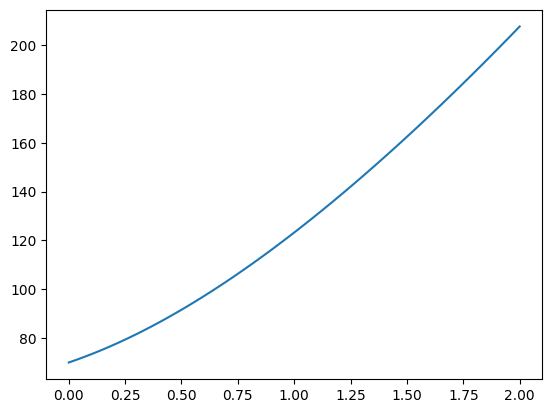

In [7]:
z = np.linspace(0, 2, 100,dtype=np.float32)
params=[70,0.3,-19,150]
plt.plot(z,H(z,params))

In [8]:
print(log_likelihood(params))

-5715.368078826819


In [9]:
# 初始化参数
nwalkers = 40
ndim = 4
nstep=1000
p0 = [70,0.3,-19,150] + 1e-4 * np.random.randn(nwalkers, ndim)

In [10]:
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

import emcee
from multiprocessing import Pool
import time


with Pool() as pool:
    start = time.time()
    # 设置emcee采样
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,pool=pool)
    sampler.run_mcmc(p0, nstep, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

64 CPUs


100%|██████████| 1000/1000 [26:12<00:00,  1.57s/it]

Multiprocessing took 1573.3 seconds


In [11]:
# 处理结果
samples = sampler.get_chain(discard=300, thin=30, flat=True)   
H0_median = np.median(samples[:, 0])
print(H0_median)
c_midian = np.median(samples[:, 1])
print(c_midian)
a_midian = np.median(samples[:, 2])
print(a_midian)
rd_midian = np.median(samples[:, 3])
print(rd_midian)

68.85580256787286
0.32761615269057753
-19.37953325780626
145.0382919009541


In [12]:
rd_midian*H0_median/100

99.8672799191361

In [13]:
np.savetxt("Chains/MC_chain_LCDM.txt", samples ,fmt='%f',delimiter=',')

Removed no burn in


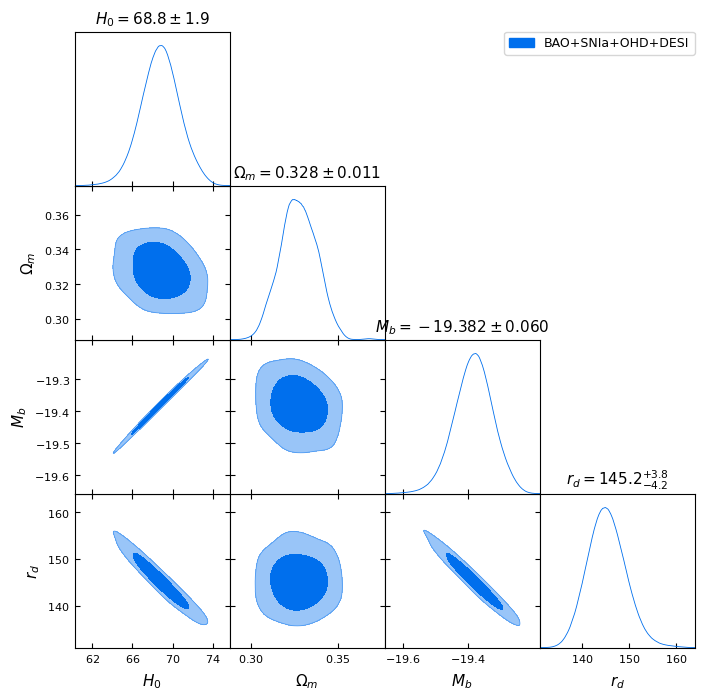

In [14]:
from getdist import plots, MCSamples
import getdist
%matplotlib inline
labels= ['H_0', '\Omega_m','M_b','r_d']
names = ['H_0', '\Omega_m','M_b','r_d']
samplesplot = MCSamples(samples=samples,names =names, labels = labels)
g = plots.get_subplot_plotter()
g.settings.alpha_filled_add=0.4
g.settings.title_limit_fontsize = 14
g.triangle_plot(samplesplot , filled=True, legend_labels=['BAO+SNIa+OHD+DESI', 'Simulation 2'], 
    legend_loc='upper right',title_limit=1)

labels= labels

[]

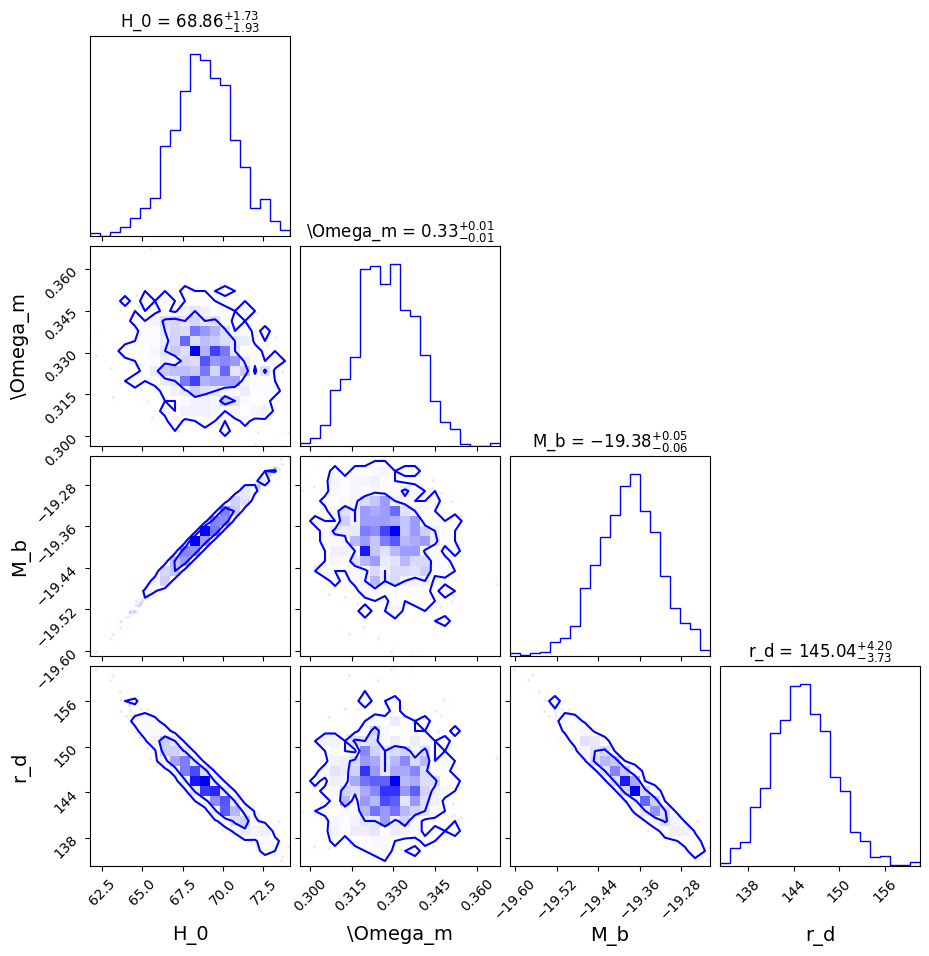

In [15]:
import corner
# 绘制一个定制的corner图
corner.corner(samples,
              labels=labels,
              fill=True,             # 填充颜色
              color='blue',          # 颜色
              levels=[0.68, 0.95],   # 显示68%、95%的置信区间
              show_titles=True,      # 显示标题
              title_kwargs={"fontsize": 12},
              label_kwargs={"fontsize": 14})
plt.plot()


/tmp/ipykernel_19968/658956434.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  ax.plot(samples[:,:,i], "k", color='black',alpha=0.3)


Text(0.5, 0, 'step number')

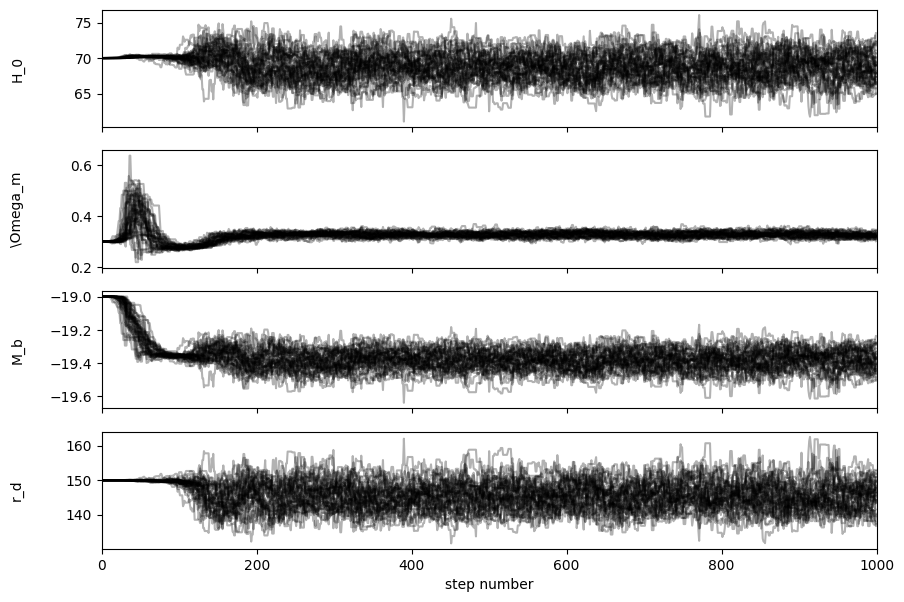

In [16]:
samples = sampler.get_chain()


fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
#samples = np.loadtxt(file_name, delimiter=',', skiprows=0, dtype=np.float32)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", color='black',alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [17]:
# 处理结果
samples = sampler.get_chain(discard=200, thin=25, flat=True)
theta_median = [] 
for n in range(ndim):
    theta_median.append(np.mean(samples[:,n]))
print(theta_median)

[68.71716088072642, 0.32769308313722145, -19.383321914732573, 145.37892699382286]


In [18]:
log_likelihood_max = log_likelihood(theta_median)
n = 2000
k = ndim  # 模型的自由参数个数
# 计算 AIC 和 BIC
AIC = 2 * k - 2 * log_likelihood_max
BIC = k * np.log(n) - 2 * log_likelihood_max

print(f"AIC: {AIC:.2f}")
print(f"BIC: {BIC:.2f}")

AIC: 2085.68
BIC: 2108.09


In [19]:
print(samplesplot.getTable().tableTex())

\begin{tabular} { l  c}

 Parameter &  95\% limits\\
\hline
{\boldmath$H_0            $} & $68.8^{+3.8}_{-3.9}        $\\

{\boldmath$\Omega_m       $} & $0.328^{+0.020}_{-0.020}   $\\

{\boldmath$M_b            $} & $-19.38^{+0.12}_{-0.12}    $\\

{\boldmath$r_d            $} & $145.2^{+8.2}_{-7.6}       $\\
\hline
\end{tabular}
